# Deep learning from scratch: homework 3

### General instructions

Complete the exercises listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself.  Feel free to add any necessary cells.  

Included with the notebook are 

- a custom utilities file called `custom_utils.py` that provides various plotting functionalities (for unit tests to help you debug) as well as some other processing code


- datasets for exercises: `unnorm_linregress_data.csv`, `highdim_multirange_linregress.csv`, `student_debt.csv`, and  `noisy_sin_sample.csv`

be sure you have these files located in the same directory where you put this notebook to work!

### When submitting this homework:
    
**Make sure all output is present in your notebook prior to submission**

In [140]:
# import autograd functionality
import autograd.numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   

# import custom utilities
import custom_utilities as util

# import various other libraries
import copy
import matplotlib.pyplot as plt

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### <span style="color:#a50e3e;">Exercise 1. </span>  Read the notes below

Yes, thats it, **there is nothing to turn in for this exercise** (yes, you will get these points for free!).  Just read the notes below!  You will find useful concepts - and blocks of code - for further exercises there.

# 1.  ``autograd`` flattening functions for easier gradient descent with networks nonlinearities

In implementing optimization algorithms like gradient descent it is quite natural to treat the optimization variable - our weights - as a *vector*.  We think about gradient descent for example we think of the combined weight update

\begin{equation}
\mathbf{w}^{k} = \mathbf{w}^{k-1} - \alpha \nabla g\left(\mathbf{w}^{k-1}\right)
\end{equation}

as a vector operation.  

This was especially true with the linear supervised learning models we saw earlier, where we used a ``predict`` function like 

\begin{equation}
\text{predict}\left(\mathbf{x},\omega\right) = w_0 + w_1x_1 + \cdots w_Nx_N
\end{equation}

which we used for linear regression and two-class classification.  Note in class we used the simpler notation $\text{predict}(x)$, but as the prediction is really a function of all the model weights we should include it too.  Here the notation $\omega$ will be used in general to denote the complete set of weights of our model - here that just means those coefficients of the linear combination  $\omega = \left \{w_0,w_1,w_2...,w_N \right \}$. 

In any case, when performing gradient descent using our linear predictor we stack those weights together making an $(N+1) \times 1$ vector inside our gradient descent module, and get to work.

The same sort of vector-wise thinking applies to kernel functions as well.  Since they have no tunable internal parameters, when we use them to perform nonlinear regression/classification we need only tune weights of their linear combination.  That is, if we use $U$ fixed kernel functions (like e.g., polynomials) $f_1,\,f_2,\,...,f_U$ our ``predict`` function is

\begin{equation}
\text{predict}\left(\mathbf{x},\omega\right) = w_0 + w_1\,f_1\left(\mathbf{x}\right) + \cdots w_U\,f_U\left(\mathbf{x}\right)
\end{equation}

Therefore when we apply our gradient descent module, those weights naturally form a vertical $(U+1) \times 1$ stack, and we go about our minimizing in the same natural way.

However now we are starting to use feedforward network / multilayer perceptron features, and [we saw in class](https://jermwatt.github.io/mlrefined/blog_posts/Nonlinear_Supervised_Learning/Part_4_multi_layer_perceptrons.html) how their many *internal* weights are naturally expressed as a sequence of *matrices* (such a sequence of matrices - taken all together - is referred to as a *tensor*).  Thus our ``predict`` and cost functions will also have layers of weight matrices, something our gradient descent module is not (yet) equipped to deal with.

Since our gradient descent function is designed to update a *vector* we will *flatten* the input cost function using a special tool that comes with ``autograd``, called ``flatten_func``.  This takes in a (mathematical) function and re-indexes its weights so that they can be dealt with as a vector.  The ``autograd`` function called ``unflatten`` can then be used to return the original structure to our weights.  

You will find these additions to the gradient descent module written below!  With this flattening ability we can now safely apply gradient descent to linear predictors, kernel predictors, and neural network predictors without worrying about the shape of our predictor's weights!

You will also find that this ``gradient_descent`` function has a built-in switch called ``version`` that allows you to easily use ``unnormalized`` or ``normalized`` gradient descent methods, as well as a parameter ``beta`` for the momentum term.  This parameter can be set to a value between 0 and 1, as a trade-off between the gradient step and the difference between the subsequent descent steps.  Setting ``beta`` to zero gives the regular gradient descent step.

In [141]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

# 2.  (Optimization tricks part 2) Data normalization and gradient descent performance

Here we discuss the general benefits of *normalizing* the *input* (also called *feature scaling*) - and *output* of a dataset in the case of regression - of a given dataset and how this can help substantially speed up gradient descent.  This is one of simplest yet most effective optimization tricks one can use when minimizing a supervised learning cost function - *using gradient descent* (other methods like *Newton's method* are invariant to this sort of scaling and work just as well without it - as well as its highly related variants (like stochastic gradient descent, which we discuss in the near future). 

## 2.1 Normalizing input (feature scaling)

Lets examine how gradient descent performs in tuning the Least Squares cost function using a simple linear regression dataset - loaded into the notebook via the Python cell below.

<IPython.core.display.Javascript object>


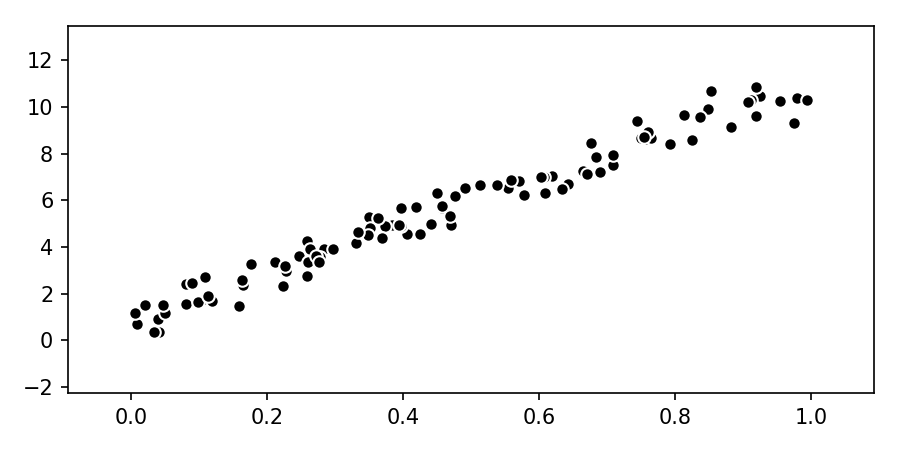

In [142]:
# load data
data = np.loadtxt('unnorm_linregress_data.csv')
x = data[:,:-1]
y = data[:,-1:]

# make copy of input and output (for later)
x_orig = copy.deepcopy(x)
y_orig = copy.deepcopy(y)

# plot everything
demo = util.Visualizer()
demo.plot_data_fit(x,y)

This data looks pretty simple - it was built as noisy samples from the line $y = 1 + 10x$ over the interval $[0,1]$.  Suppose we did not know about this true underlying model but want to perform linear regression on this dataset.  We use the simple linear ``predict`` function

\begin{equation}
\text{predict}\left(x,\omega\right) = w_0 + w_1x
\end{equation}

Our simple predict Python in Python is given below.

In [143]:
# make our predict function
def predict(x,w):
    return w[0] + x*w[1]

Notice here that with this ``Python`` implementation of the ``predict`` function we can make a prediction of a single point or the entire set of inputs.  All we need to do is control which points we input as ``x``.   So, as shown below, we can just shove the entire input through and get predictions for all points simultaneously.

In [166]:
# make predictions for the entire set of inputs simultaneously
w = np.random.randn(2,1)   # make random weights for our prediction
print ('predictions for all our poitns')
print (predict(x,w).T)

predictions for all our poitns
[[ 1.41254145  1.33364006  1.34548325  1.4166753   1.33824288  1.25779089
   1.20971168  1.3653695   1.27782567  1.24994487  1.30135644  1.22160071
   1.25923937  1.36420889  1.40364919  1.26804267  1.39780824  1.27506011
   1.39778742  1.22444164  1.28768713  1.28239791  1.41229511  1.319524
   1.39539994  1.36530241  1.40185244  1.31040947  1.27356803  1.33540339
   1.40368449  1.22528233  1.26059357  1.21080563  1.25624119  1.36004167
   1.27227379  1.22286615  1.41923084  1.2577933   1.38696034  1.2843721
   1.41990226  1.23807015  1.41106153  1.29804458  1.25698229  1.22283504
   1.36796249  1.32253977  1.23064331  1.37297973  1.41383689  1.37555209
   1.36497497  1.29643947  1.3453327   1.21516448  1.39975215  1.24048204
   1.26805751  1.20665036  1.34584852  1.36110383  1.28999111  1.3151966
   1.24570726  1.32603315  1.33057254  1.34987947  1.3831833   1.23701846
   1.36238569  1.31982216  1.34059067  1.2583942   1.29107096  1.36159007
   1.335404

This is good to note since because going forward we will want to write all of our ``predict`` functionality, features, and cost functions as compactly as possible using ``Numpy`` (vector/matrix/tensor) operations - while still making them legible -  since these are far more efficient than writing raw for loops in ``Python``.

In any case - we then aim to tune the parameters to minimize the Least Squares cost function of this predictor over our entire dataset 

\begin{equation}
g\left(w_0,w_1\right) = \sum_{p=1}^{P}\left(\text{predict}\left(x_p,\omega\right) - y_p\right)^2.
\end{equation}

Below is a compact form of this Least Squares function in ``Python``.  Notice here we shove the entire set of inputs through ``predict`` here at once, computing all their predictions, and then compare them to the entire set of outputs. 

In [145]:
# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

Notice in the case of our current dataset how this cost function takes in just two parameters we can plot e.g., its contour plot.  We do this in the ``Python`` cell below.  

<IPython.core.display.Javascript object>


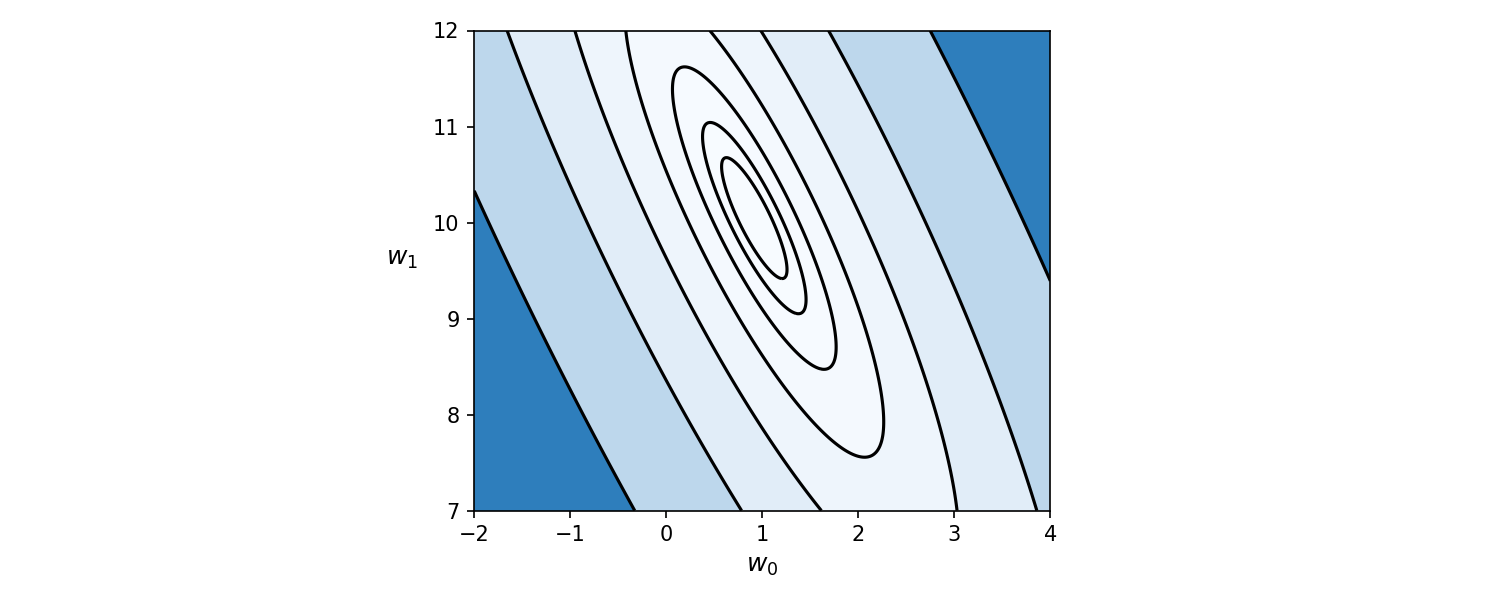

In [146]:
# plot contour of cost
demo.draw_setup(least_squares,num_contours = 7,xmin = -2,xmax = 4,ymin = 7,ymax = 12)

Notice: 


- How **elliptical** its contours are (!) - this is due to the fact that the cost function value is much more sensitive the selected slope value $w_1$ than the bias $w_0$.  


- The plot is color coded: the darker the region, the larger the cost value is there (conversely the lighter the region the smaller the cost value is), this is how all future contour plots are color-coded as well.


- The cost value decreases as the elliptical contours get smaller, with the minimum being located inside the smallest contour shown.

We can now minimize the Least Squares cost, here using gradient descent.  However as discussed in class, gradient descent (regardless of the version we use) does quite a poor job making progress when traveling down *long narrow valleys*.  The long axis of an elliptical contour (like the one shown above) like this create precisely this sort of scenario!  Unless we luck out and initialize directly along the *short axes* of such an elliptical contour-having cost function, gradient descent will need to take a large number of steps to reach a minimum.  

We illustrate this with the run of $100$ unnormalized gradient descent steps initialized at $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ with a steplength parameter $\alpha = 10^{-3}$.  Here $10^{-3}$ was the largest value of $\alpha$ of the form $10^{-\gamma}$ we found that produced convergence (larger values of $\alpha$ caused gradient descent to diverge).  The next Python cell performs this run and produces a cost function plot showing the cost value at each gradient descent step.

<IPython.core.display.Javascript object>


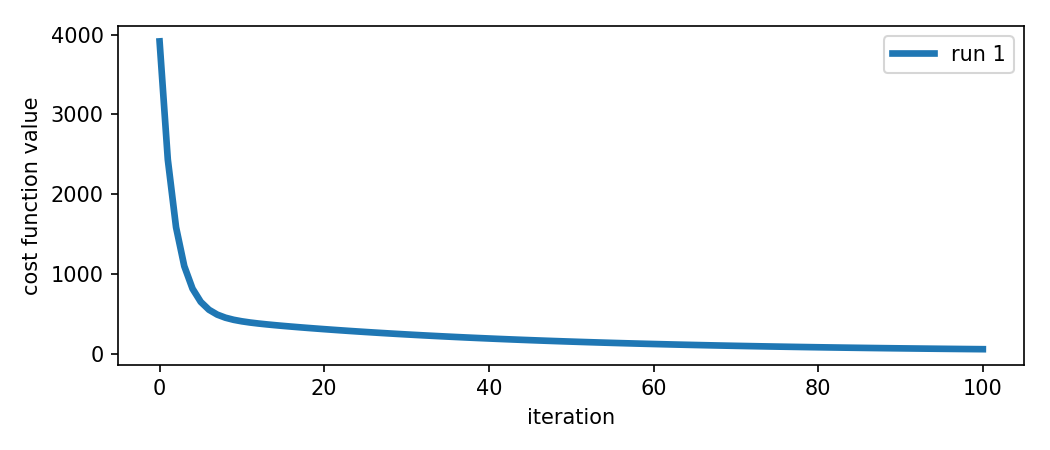

In [147]:
# run gradient descent initialized at 0
alpha = 10**(-3)
max_its = 100
w_init = np.zeros((2,1))

# run gradient descent
weight_history = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'unnormalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]
demo.compare_regression_histories(histories)

We can plot these descent steps right on our contour plot to see just how the method slows down due to the long narrow valley.  Here the steps are colored from green to red as gradient descent begins (green) to when it ends (red).  From this perspective we can see that we still have a way to travel to reach the minimum of the cost function.

<IPython.core.display.Javascript object>


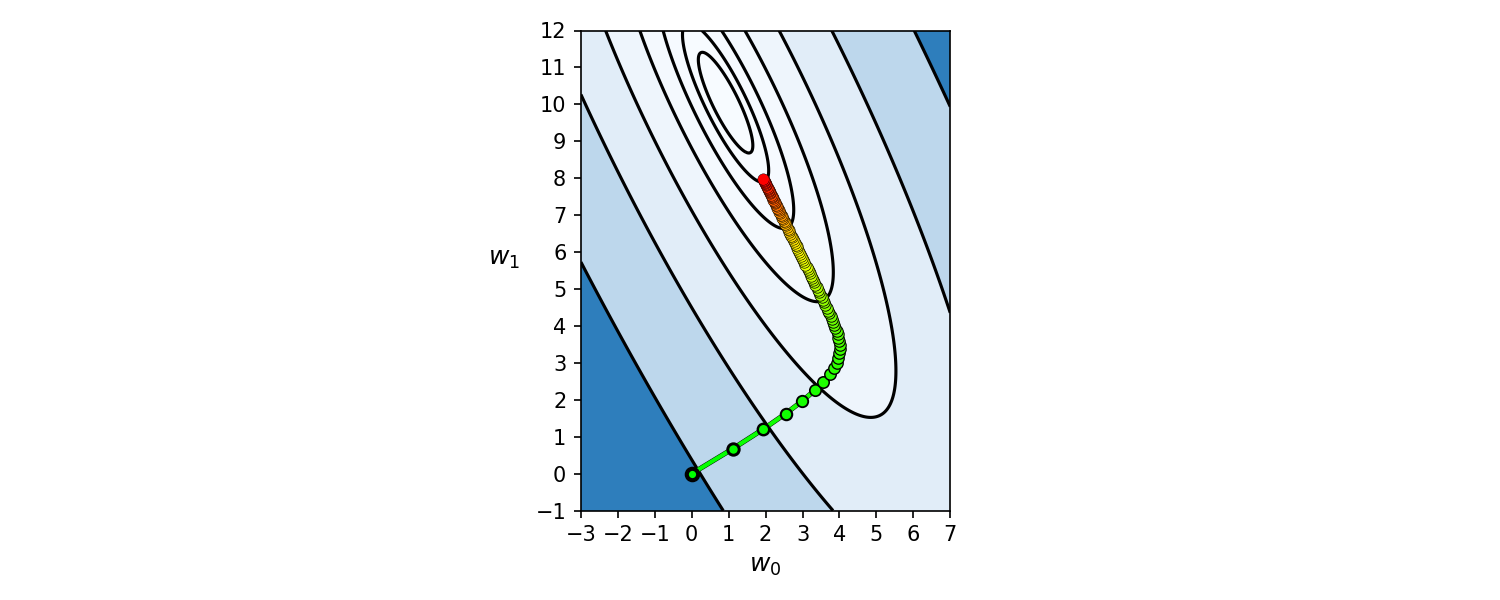

In [148]:
# plot history on contours
demo.draw_setup(least_squares,num_contours = 7,weight_history = weight_history, xmin = -3,xmax = 7,ymin = -1,ymax = 12)


Plotting the line given by the final set of weights learned in this run of gradient descent - those associated with the final red point plotted on the contour plot above - we can see that the fact that these weights lie so far from the true minimum of the cost function truly affect the line's quality - we get poor fit considering how simple the dataset is.

<IPython.core.display.Javascript object>


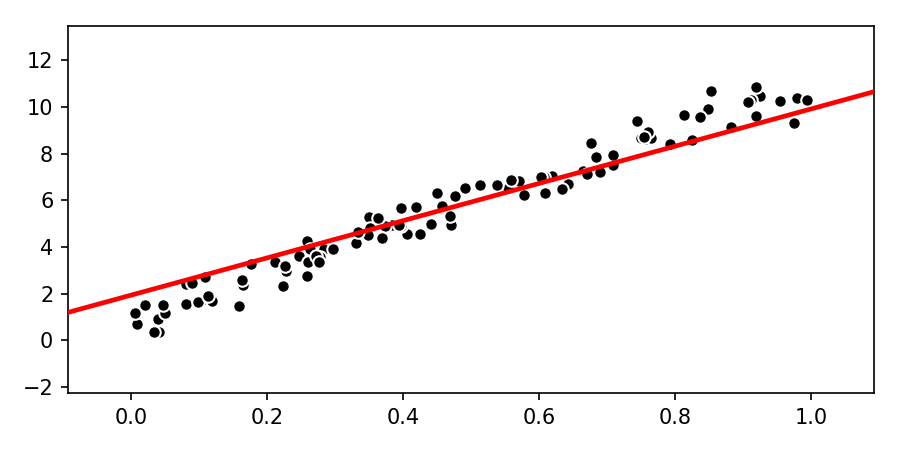

In [149]:
# the original data and best fit line learned from our gradient descent run
w = weight_history[-1]  # take the final weight learned from our history
demo.plot_data_fit(x,y,predict = predict,weights = w)

Now, we could of course run gradient descent longer to get a better fit.  But this issue of long narrow valleys considerably slowing down gradient descent is a broader issue, and we are here to learn about ways of ameliorating this common problem with our cost functions (i.e., not just running gradient descent for many more steps, as this is hugely wasteful computationally speaking).

We can do something quite simple that hugely ameliorate this issue: *normalize the input of our dataset*.  There a number of ways one can normalize a list of numbers like our input $\left\{x_p\right\}_{p=1}^{P}$, the most common way is simply to subtract off its mean and divide by its standard deviation.  Doing this centers our data at zero along the input axis.

Denoting the mean by $\mu$ and standard deviation by $\sigma$ these values are simply

\begin{array}
\
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \\
\sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}
\end{array}

We can compute these values quite easily using built in numpy functions as shown below. 

In [150]:
# compute the mean and standard deviation of the input
x_mean = np.mean(x)
x_std = np.std(x)

Then to normalize the input we take each input $x_p$ and normalize it as

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

A ``Python`` function for normalizing a generic list of numbers in this way - given the mean and standard deviation of that list - can be written as shown in the next cell.  Note: this normalizes every element of the list in one step (using ``Numpy`` operations) - quite efficiently.

In [151]:
# a normalization function 
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

Lets normalize our input using the function above.

In [152]:
# cache a copy of the original input, then normalize
x_orig = copy.deepcopy(x)
x = normalize(x,x_mean,x_std)

Such a small change to the input of our dataset produces resounding changes to the (Least Squares) cost function.  Lets take a look at the contour plot of our Least Squares now that we have normalized our input.  

<IPython.core.display.Javascript object>


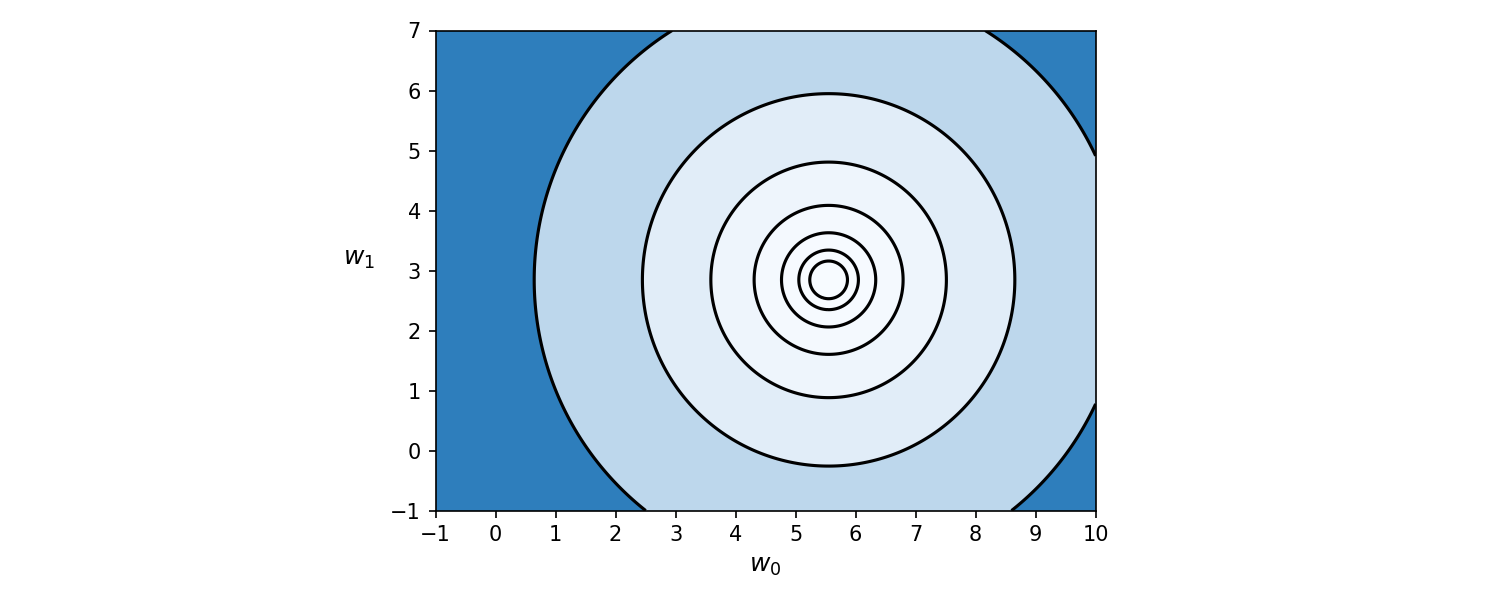

In [153]:
# show contour plot
demo.draw_setup(least_squares,num_contours = 7, xmin = -1,xmax = 10,ymin = -1,ymax = 7)

Notice: 


- How **circular** its contours are (!) - this is due to the fact that input-normalization has forced the cost function to treat the slope $w_1$ and bias $w_0$ more equivalently (it is no longer more sensitive to the value of one over the other). 


- By ridding ourselves of elliptical contours we have rid ourselves of the *long narrow valley* we had before, so gradient descent will have a much easier time finding the minimum of this adjusted cost function.  


- The same benefits can be gained in normalizing the input of a classification dataset as well!


- The plot is again color coded: the darker the region, the larger the cost value is there (conversely the lighter the region the smaller the cost value is), this is how all future contour plots are color-coded as well.


- The cost value decreases as the circular contours get smaller, with the minimum being located inside the smallest contour shown.

In the next ``Python`` cell we repeat our previous run of unnormalized gradient descent - beginning at the same initial point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$, using a steplength parameter $\alpha = 10^{-3}$.   However here we will only take $25$ steps instead of $100$ as we did before, since we basically reach the minimum after just a few steps now.

<IPython.core.display.Javascript object>


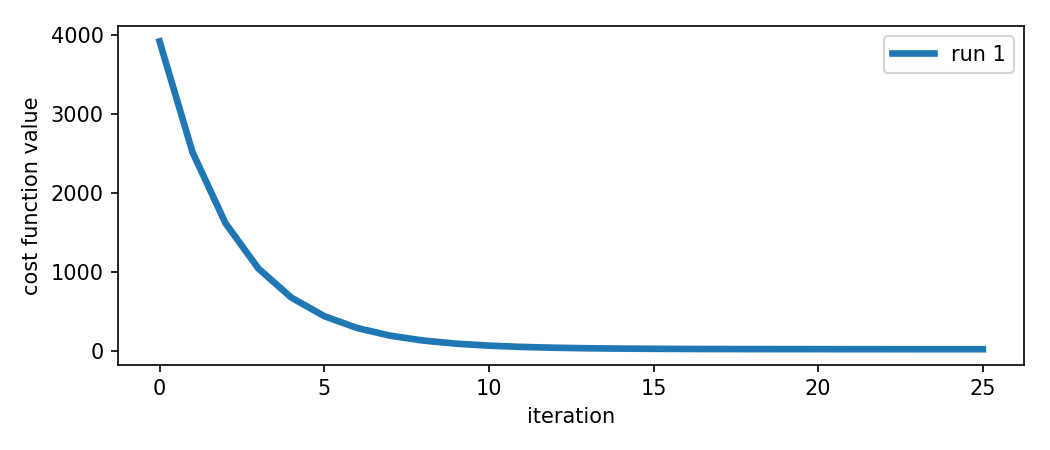

In [154]:
# run gradient descent initialized at 0
alpha = 10**(-3)
max_its = 25
w_init = np.zeros((2,1))

# run gradient descent
weight_history = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'unnormalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]
demo.compare_regression_histories(histories)

Lets look at those gradient descent steps drawn on the contour plot! 

<IPython.core.display.Javascript object>


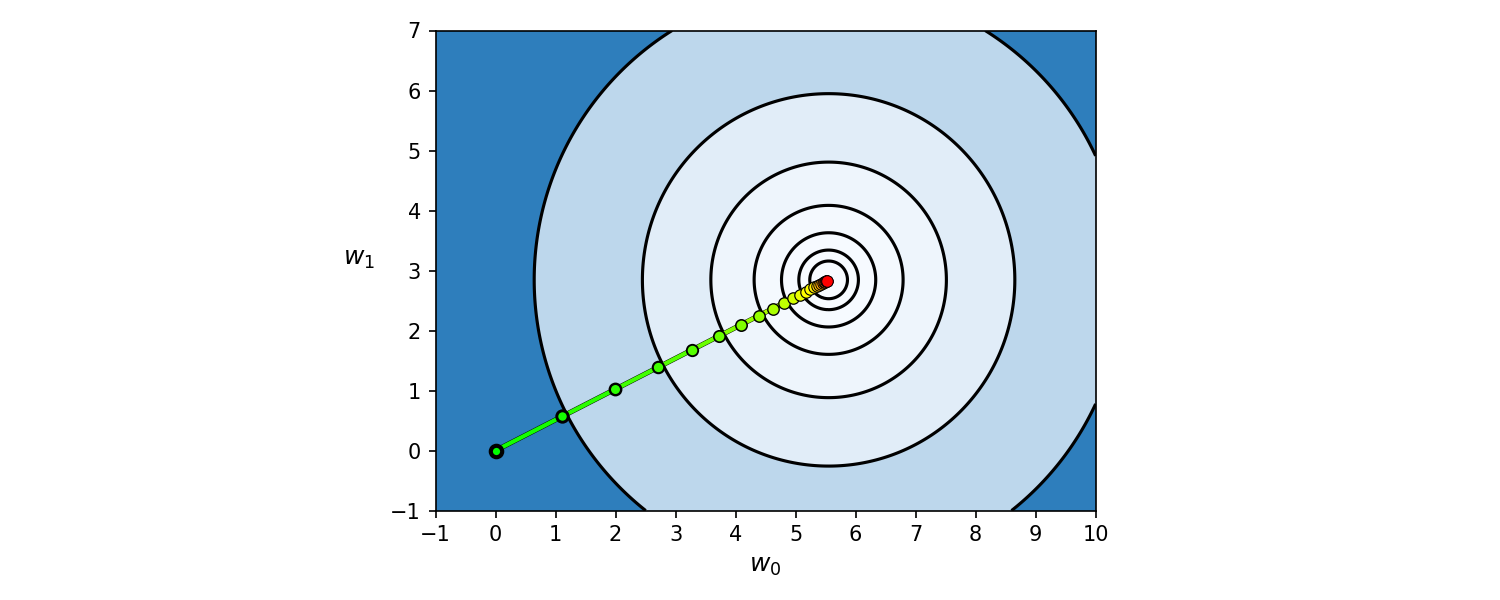

In [155]:
# plot history on contours
demo.draw_setup(least_squares,num_contours = 7,weight_history = weight_history, xmin = -1,xmax = 10,ymin = -1,ymax = 7)

Wow - using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

Let us plot the fit associated with the final set of weights (the final red point above) on top of our normalized dataset below.   This will result - of course - in a much better.  (visually compare the fit below to the one we got previously!)  

<IPython.core.display.Javascript object>


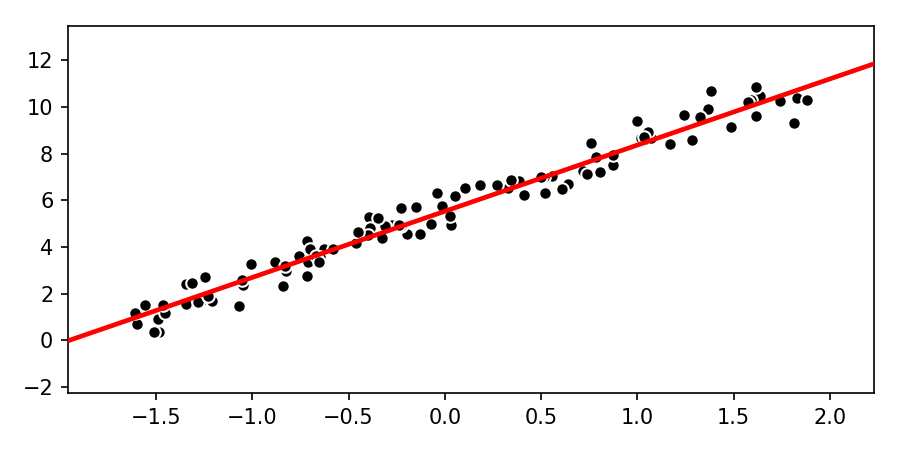

In [156]:
# plot best fit line to normalized data
demo.plot_data_fit(x,y,predict = predict,weights = weight_history[-1])

Looks good!  But notice one thing: the horizontal axis.  This is our *input-normalized* dataset - not our original one!  What happens when we plot our prediction directly on our original dataset?  Take a look - its done below.

<IPython.core.display.Javascript object>


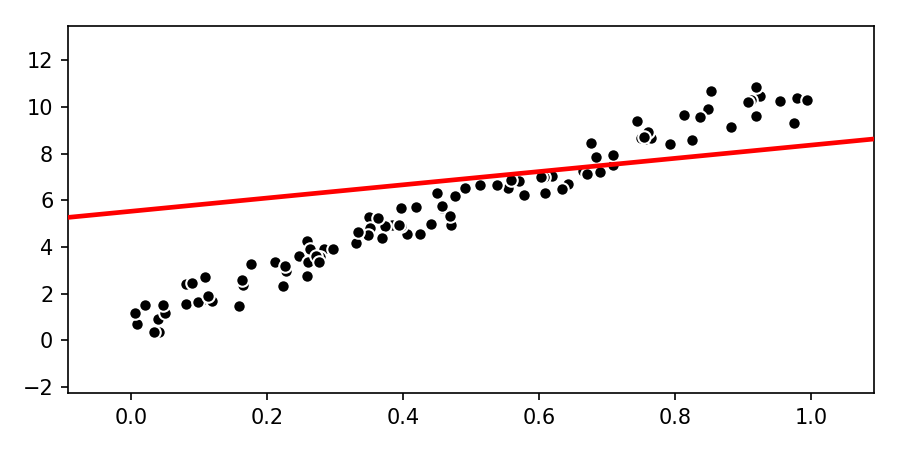

In [157]:
# plot best fit line to original data - x_orig
demo.plot_data_fit(x_orig,y,predict = predict,weights = weight_history[-1])

There is nothing wrong above - remember we normalized the input, then fit the line.  We just need to translate our trained model (our ``predict`` function with learned weights) back to the input range of our original data.

This is an easy fix - we just to include our input-normalization explicitly in the prediction function ``predict``.  This way when we plug in our original data, or new test data (like the points we use to construct the line visually), the fit will be translated properly.

To distinguish this from our prediction function above, ``predict_testing`` function (this is what we plug in any *test data* into to e.g., make a prediction, or visualize our regressor in this case)

\begin{equation}
\text{predict_testing}\left(x,\omega\right) = w_0 + w_1\left(\frac{x - \mu}{\sigma}\right)
\end{equation}

Notice: this input-normalized ``predict_testing`` function still relates original inputs $x$ to original outputs $y$, it simply normalizes the inputs prior to plugging them into the (linear) model.  Also note here that the *weights are tuned here*.

Lets write this in Python as well.  In the Python implementation we can write out each step - normalization and model evaluation - in two discrete steps.

In [158]:
# our input-normalized predict function
def predict_testing(x,w):
    # normalize data
    x_normed = normalize(x,x_mean,x_std)
    
    # compute linear model
    vals = w[0] + x_normed*w[1]
    return vals

Now when we plug in our original input it will be properly normalized, and we thus translate our prediction to work properly with our original data.

<IPython.core.display.Javascript object>


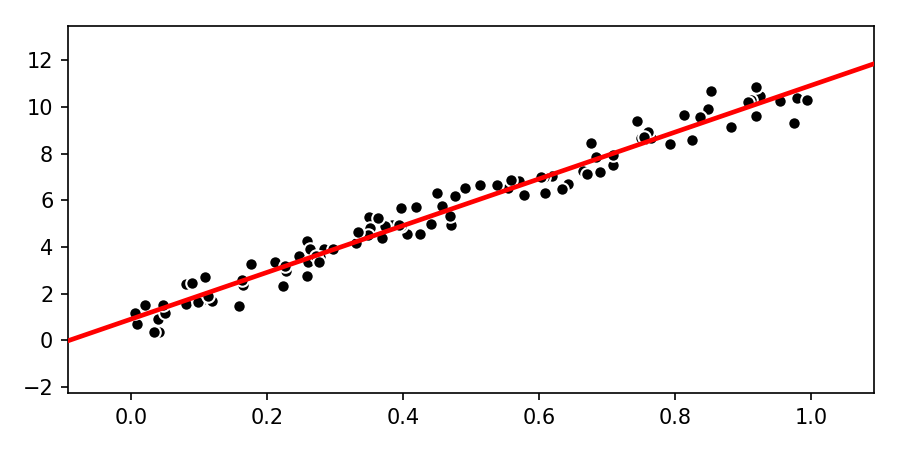

In [159]:
# plot best fit line to original data - x_orig
x = copy.deepcopy(x_orig)  # re-assign our original input to the variable 'x'
demo.plot_data_fit(x,y,predict = predict_testing,weights = weight_history[-1])

## 2.2  Normalizing the output of *regression* datasets

Do we gain anything from normalizing the output of a dataset, like we did the input, in terms of speeding up gradient descent's progress towards a minimum?  Lets look at our simple dataset again and see if we cannot intuit what might happen more generally.

First we normalize the input and output as

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu_x}{\sigma_x}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,y_p \longleftarrow \frac{y_p - \mu_y}{\sigma_y}
\end{equation}

where $\mu_x$ and $\sigma_x$ are the mean and standard deviation of the input, and likewise $\mu_y$ and $\sigma_y$ are the mean and standard deviation of the output.

In [160]:
# cache a copy of the input, then normalize it
x_orig = copy.deepcopy(x)
x_mean = np.mean(x)
x_std = np.std(x)
x = normalize(x,x_mean,x_std)

# cache a copy of the output, then normalize it
y_orig = copy.deepcopy(y)
y_mean = np.mean(y)
y_std = np.std(y)
y = normalize(y,y_mean,y_std)

Using the same ``predict`` function we used for training above, below we run the same gradient descent procedure as with the prior example.  We then plot the cost function history of this run.

<IPython.core.display.Javascript object>


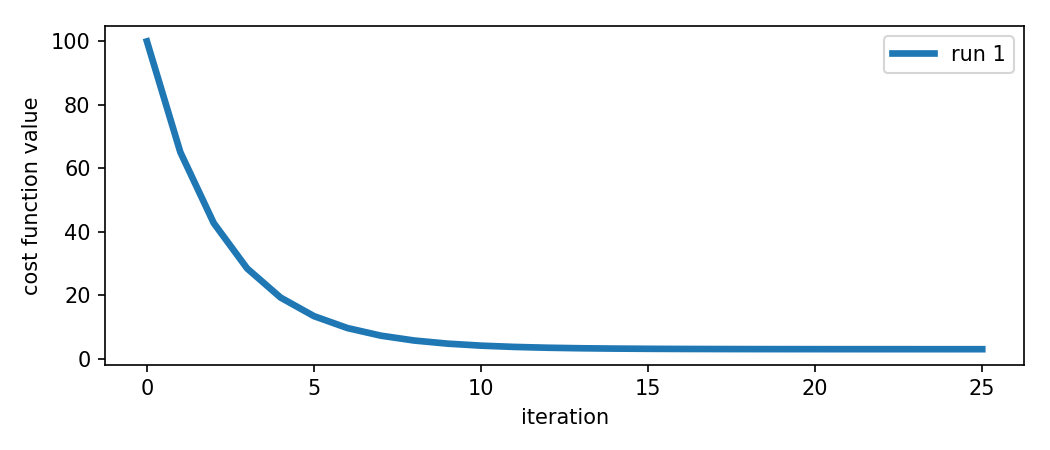

In [161]:
# run gradient descent initialized at 0
alpha = 10**(-3)
max_its = 25
w_init = np.zeros((2,1))

# least squares
least_squares = lambda w: np.sum((predict(x,w) - y)**2)

# run gradient descent
weight_history = gradient_descent(least_squares,w_init,alpha,max_its,beta = 0,version = 'unnormalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]
demo.compare_regression_histories(histories)

While the general shape of this cost function plot looks similar to that of the previous run (where we only normalized the input) note the difference in cost function value scale on the vertical axis: here we are an order of magnitude lower!   Meaning that at our initialization (at the origin) we are considerably closer to the minimum then previously, and move closer towards it in our descent run.

Lets look at the contour plot of our cost function now that we have normalized both the input and output of the function.  We show the gradient descent steps on top of the contour plot in the usual way as well.

<IPython.core.display.Javascript object>


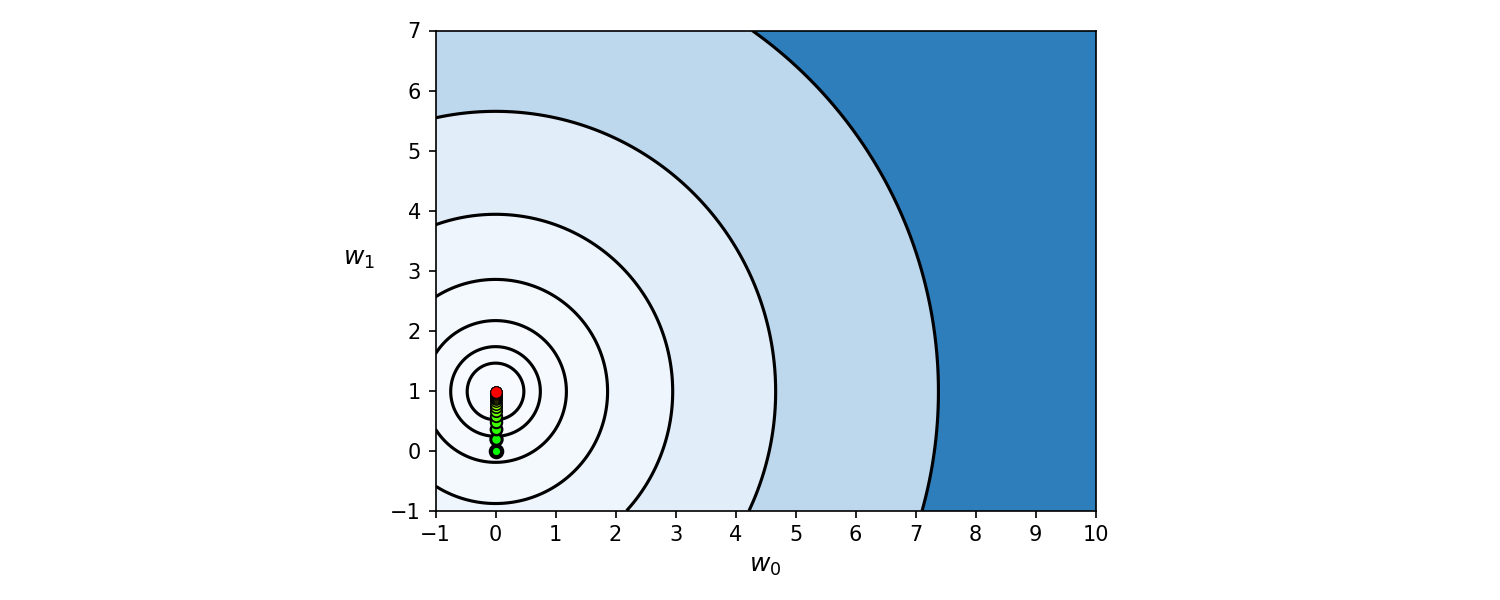

In [162]:
# plot history on contours
demo.draw_setup(least_squares,num_contours = 7,weight_history = weight_history, xmin = -1,xmax = 10,ymin = -1,ymax = 7)

Comparing this to the previous contour plot, we still have circular contours but now - since we have normalized the output - the minimum has moved much closer to the origin than it was before.  This was particularly beneficial in the case here since have been initializing our run(s) of gradient descent at the origin.  But even with a random initialization - for this particular dataset - we could think of this as being somewhat helpful, since rarely do we initialize weights to very large numbers.

Reflecting on this for a moment, it seems that this behavior will be reflected more generally when normalizing the output of a *regression* dataset (we would never want to 'normalize' the output  - i.e., the set of labels - of a classification dataset!).  That is, particularly when the output lies outside the unit interval, normalizing the output will drag the minimum of a cost function closer to the origin.  Again this could be helpful since we typically initialize gradient descent with  small (often random) weights.

Note here how we must adjust our ``predict`` function for test data in a slightly different way than previous - since we have normalized the output here as well.  Our ``predict_testing`` function needs to take in our original data and normalize both input and output.  We can make this adjustment as

\begin{equation}
\text{predict_testing}\left(x,\omega\right) = \left( w_0 + w_1\left(\frac{x - \mu_x}{\sigma_x}\right) \right) \sigma_y + \mu_y
\end{equation}

(why is this do you think?) and can implement this in ``Python`` as

In [163]:
# our input-normalized predict function
def predict_testing(x,w):
    # normalize data
    x_normed = normalize(x,x_mean,x_std)
    
    # compute linear model
    vals = w[0] + x_normed*w[1]
    
    # re-normalize from output
    vals = vals*y_std + y_mean
    return vals

Now we can plot our data and learned linear model - using our original dataset - as shown below.

<IPython.core.display.Javascript object>


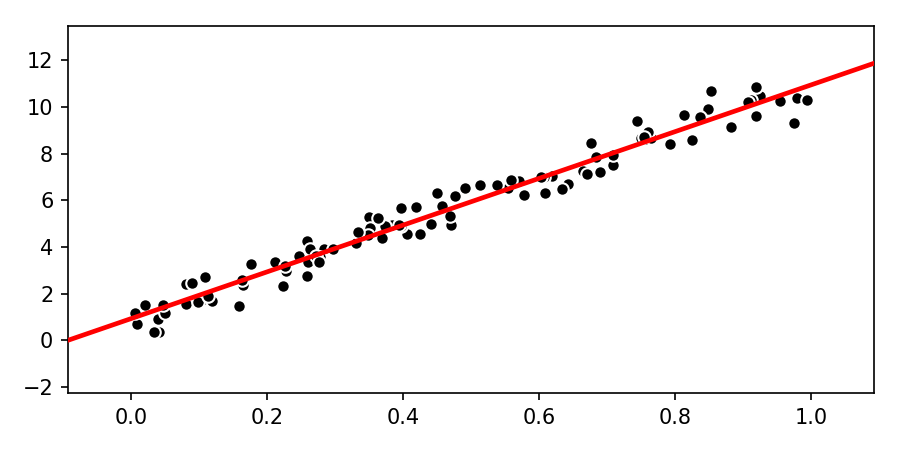

In [164]:
# plot best fit line to original data - x_orig
x = copy.deepcopy(x_orig)  # re-assign our original input to the variable 'x'
y = copy.deepcopy(y_orig)  # re-assign our original input to the variable 'x'
demo.plot_data_fit(x,y,predict = predict_testing,weights = weight_history[-1])